In [1]:
%cd "../.."

/home/ensai/projet-statistique-2022


In [2]:
from gensim import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import euclidean_distances
import hdbscan as HD
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.manifold import TSNE

import seaborn as sns
import plotly.express as px


from word_embedding.distance_wmd import *
import doc_embedding.moyenne as moyenne
from reduction_dim.correlation_matrix import *
import clustering.fit_clustering as CL 

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
with open('data/docs.json', encoding = "utf8") as f:
    docs = json.load(f)

dict_moy_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    ev = models.KeyedVectors.load_word2vec_format(f"data/tunning/{modele}.kv")
    #Read moy matrix
    dict_moy_embedding[modele] = {}
    dict_moy_embedding[modele]["TF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF')
    dict_moy_embedding[modele]["TFIDF"] = moyenne.word_emb_vers_doc_emb_moyenne(docs, ev, methode = 'TF-IDF')

In [4]:
dict_wmd_embedding = {}
for modele in ["glove","cbow","skipgram"]:
    #Read moy matrix
    dict_wmd_embedding[modele] = {}
    dict_wmd_embedding[modele]["Distance"] = np.array(lecture_fichier_distances_wmd(f"distances_{modele}.7z"))
    if modele != "glove":
        dict_wmd_embedding[modele]["MDS"] = np.array(pd.read_csv(f"data/tunning/MDS/{modele}_mds_embedding.csv",sep=";",header=0))

In [5]:
dict_embedding = {}
dict_embedding["WMD"] = dict_wmd_embedding
dict_embedding["Moyenne"] = dict_moy_embedding

In [6]:
df_hdbscan_clustering = pd.read_csv("data/tunning/clustering/hdbscan.csv",sep=";")
df_hdbscan_clustering["clustering"] = "hdbscan"
df_kmeans_clustering = pd.read_csv("data/tunning/clustering/kmeans.csv",sep=";")
df_gmm_clustering = pd.read_csv("data/tunning/clustering/gmm.csv",sep=";")
df_gmm_clustering["clustering"] = "gmm"
df_clustering = pd.concat([df_hdbscan_clustering,df_kmeans_clustering,df_gmm_clustering])
df_clustering.head()

voisinage  min_cluster_size     distance  K  silhouette  Cal-Harabasz  \
0       44.0              10.0  precomputed  3    0.368642           NaN   
1       27.0              13.0  precomputed  3    0.380373           NaN   
2       27.0              14.0  precomputed  3    0.380373           NaN   
3       12.0              10.0  precomputed  3    0.377630           NaN   
4        8.0              10.0  precomputed  3    0.347484           NaN   

       DBCV  non_classes  perplexity wordEmbedding docEmbedding docEmbedding2  \
0  0.230799        474.0         NaN          cbow          WMD      Distance   
1  0.230429        427.0         NaN          cbow          WMD      Distance   
2  0.230429        427.0         NaN          cbow          WMD      Distance   
3  0.197934        427.0         NaN          cbow          WMD      Distance   
4  0.197650        551.0         NaN          cbow          WMD      Distance   

  clustering initialisation  nb_iter  tolerance  val_obj covariance  BIC  
0    hdbscan            NaN      NaN        NaN      NaN        NaN  NaN  
1    hdbscan            NaN      NaN        NaN      NaN        NaN  NaN  
2    hdbscan            NaN      NaN        NaN      NaN        NaN  NaN  
3    hdbscan            NaN      NaN        NaN      NaN        NaN  NaN  
4    hdbscan            NaN      NaN        NaN      NaN        NaN  NaN

# Clustering Avant Tsne

In [7]:
df_clustering_before = df_clustering.loc[(df_clustering["perplexity"].isna())].reset_index()

In [8]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size     distance  K  silhouette  \
0         0       44.0              10.0  precomputed  3    0.368642   
1530  10710        7.0              10.0    euclidean  3    0.162009   
7650  53550       43.0              11.0  precomputed  3    0.318635   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
0              NaN  0.230799        474.0         NaN          cbow   
1530     30.999241  0.179658       1406.0         NaN         glove   
7650           NaN  0.407641        378.0         NaN      skipgram   

     docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
0             WMD      Distance    hdbscan            NaN      NaN        NaN   
1530      Moyenne            TF    hdbscan            NaN      NaN        NaN   
7650          WMD      Distance    hdbscan            NaN      NaN        NaN   

      val_obj covariance  BIC  
0         NaN        NaN  NaN  
1530      NaN        NaN  NaN  
7650      NaN        NaN  NaN

In [9]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  \
8458    199        NaN               NaN      NaN  2    0.518736   
8998   1779        NaN               NaN      NaN  2    0.418284   
9139   2856        NaN               NaN      NaN  2    0.665797   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
8458  14238.411443 -0.789848          NaN         NaN          cbow   
8998     59.252895 -0.265205          NaN         NaN         glove   
9139   2705.997782 -0.582056          NaN         NaN      skipgram   

     docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
8458      Moyenne         TFIDF     kmeans         random     10.0     0.0001   
8998      Moyenne         TFIDF        gmm            NaN      NaN        NaN   
9139      Moyenne         TFIDF        gmm            NaN      NaN        NaN   

        val_obj covariance           BIC  
8458  1183.0813        NaN           NaN  
8998        NaN       diag -3.329810e+07  
9139        NaN       tied -5.474153e+04

In [10]:
df_clustering_before.loc[df_clustering_before.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  \
8441    182        NaN               NaN      NaN  4    0.428655   
8519    572        NaN               NaN      NaN  2    0.096188   
8571    936        NaN               NaN      NaN  3    0.369723   

      Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
8441  15454.151975 -0.784046          NaN         NaN          cbow   
8519    236.166438 -0.591706          NaN         NaN         glove   
8571   6463.645060 -0.867900          NaN         NaN      skipgram   

     docEmbedding docEmbedding2 clustering initialisation  nb_iter  tolerance  \
8441      Moyenne         TFIDF     kmeans      k-means++     10.0     0.0001   
8519      Moyenne            TF     kmeans      k-means++     10.0     0.0001   
8571      Moyenne         TFIDF     kmeans      k-means++     10.0     0.0001   

         val_obj covariance  BIC  
8441  502.645780        NaN  NaN  
8519    0.431966        NaN  NaN  
8571  869.287271        NaN  NaN

# Clustering Apres Tsne

In [11]:
df_clustering_after = df_clustering.loc[(df_clustering["perplexity"].notna())].reset_index()

In [12]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["DBCV"].idxmax()]

index  voisinage  min_cluster_size   distance    K  silhouette  \
35955  42075       32.0             450.0  euclidean    4   -0.202506   
26010  30600        7.0              10.0  euclidean  222   -0.678185   
42075  49725       28.0              10.0  euclidean   67   -0.241299   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
35955   1656.990326  0.179336       5538.0       200.0          cbow   
26010     52.858622  0.217866       4825.0       150.0         glove   
42075    161.490846  0.208799       5039.0        75.0      skipgram   

      docEmbedding docEmbedding2 clustering initialisation  nb_iter  \
35955      Moyenne            TF    hdbscan            NaN      NaN   
26010      Moyenne         TFIDF    hdbscan            NaN      NaN   
42075      Moyenne            TF    hdbscan            NaN      NaN   

       tolerance  val_obj covariance  BIC  
35955        NaN      NaN        NaN  NaN  
26010        NaN      NaN        NaN  NaN  
42075        NaN      NaN        NaN  NaN

In [13]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["silhouette"].idxmax()]

index  voisinage  min_cluster_size distance  K  silhouette  \
52816    714        NaN               NaN      NaN  3    0.514020   
52202   2076        NaN               NaN      NaN  3    0.395142   
55012   3170        NaN               NaN      NaN  2    0.493039   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
52816  14089.783315 -0.632999          NaN       200.0          cbow   
52202   8052.595624 -0.847480          NaN       200.0         glove   
55012  12947.772932 -0.577367          NaN       200.0      skipgram   

      docEmbedding docEmbedding2 clustering initialisation  nb_iter  \
52816      Moyenne         TFIDF        gmm            NaN      NaN   
52202          WMD      Distance     kmeans      k-means++     10.0   
55012      Moyenne         TFIDF        gmm            NaN      NaN   

       tolerance      val_obj covariance            BIC  
52816        NaN          NaN       full  154273.015316  
52202     0.0001  1957373.375        NaN            NaN  
55012        NaN          NaN       diag  161156.436097

In [14]:
df_clustering_after.loc[df_clustering_after.groupby(["wordEmbedding"])["Cal-Harabasz"].idxmax()]

index  voisinage  min_cluster_size distance   K  silhouette  \
50776    338        NaN               NaN      NaN  14    0.404300   
52050   1924        NaN               NaN      NaN  10    0.373191   
51400   1092        NaN               NaN      NaN  14    0.383962   

       Cal-Harabasz      DBCV  non_classes  perplexity wordEmbedding  \
50776  24527.133503 -0.618270          NaN       200.0          cbow   
52050   8995.073630 -0.757997          NaN        50.0         glove   
51400  14189.799335 -0.630786          NaN       200.0      skipgram   

      docEmbedding docEmbedding2 clustering initialisation  nb_iter  \
50776      Moyenne         TFIDF     kmeans      k-means++     10.0   
52050          WMD      Distance     kmeans         random     10.0   
51400      Moyenne         TFIDF     kmeans         random     10.0   

       tolerance       val_obj covariance  BIC  
50776     0.0001  2.545374e+05        NaN  NaN  
52050     0.0001  3.064856e+06        NaN  NaN  
51400     0.0001  3.457451e+05        NaN  NaN

# Plot ScatterPlot

In [21]:
def plot_best(df_clustering,dict_embedding,clustering_metric="silhouette",modele="cbow"):
    best_model = df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmin()] if clustering_metric == "BIC" else df_clustering.loc[df_clustering.groupby(["wordEmbedding"])[clustering_metric].idxmax()]
    best_model = best_model[best_model["wordEmbedding"]==modele]

    if len(best_model) > 0:
        tsne_metric = "precomputed" if best_model["docEmbedding2"].values[0] == "Distance" else "euclidean"
        first_reduce = best_model["perplexity"].notna().values[0]

        doc_embedding = dict_embedding[best_model["docEmbedding"].values[0]][modele]

        tsne = TSNE(n_components = 2, perplexity=200, n_iter=2000, random_state=0,metric=tsne_metric)
        tsne_embedding = tsne.fit_transform(doc_embedding[best_model["docEmbedding2"].values[0]])
        clustering_data = tsne_embedding if first_reduce else doc_embedding[best_model["docEmbedding2"].values[0]]

        type_clustering = best_model["clustering"].values[0].upper()

        if type_clustering == "HDBSCAN":
            clust_model = HD.HDBSCAN(min_cluster_size=int(best_model["min_cluster_size"].values[0]), metric = best_model["distance"].values[0],min_samples=int(best_model["voisinage"].values[0]))
        elif type_clustering == "GMM":
            clust_model = GMM(n_components=best_model["K"].values[0],covariance_type=best_model["covariance"].values[0])
        elif type_clustering == "KMEANS":
            clust_model = KMeans(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0])
        elif type_clustering == "KMEDOIDES":
            clust_model = KMedoids(n_clusters = best_model["K"].values[0], init = best_model["initialisation"].values[0], metric = 'precomputed')

        labels = clust_model.fit_predict(np.array(clustering_data).astype(np.float64))

        color_palette = sns.color_palette('Paired', len(np.unique(labels)))
        cluster_colors = [color_palette[x] if x >= 0 else (0.5, 0.5, 0.5) for x in labels]

        title = f"Best DocEmbedding {type_clustering} Clustering based on {clustering_metric}"
        subtitle1 = f"WordEmbedding: {modele} - DocEmbedding: {best_model['docEmbedding'].values[0]} {best_model['docEmbedding2'].values[0]} - Reducing Before Clustering: {first_reduce}" 
        subtitle2 = f"Number of cluster: {len(np.unique(labels))} - Silhouette: {round(best_model['silhouette'].values[0],2)} - DBCV: {round(best_model['DBCV'].values[0],2)}"
        title=f"{title}\n{subtitle1}\n{subtitle2}"


        return labels,tsne_embedding, cluster_colors, title
    else: 
        return [None, None,None,None]

############################################################################################################################
                                                  SKIPGRAM                                                                         
############################################################################################################################


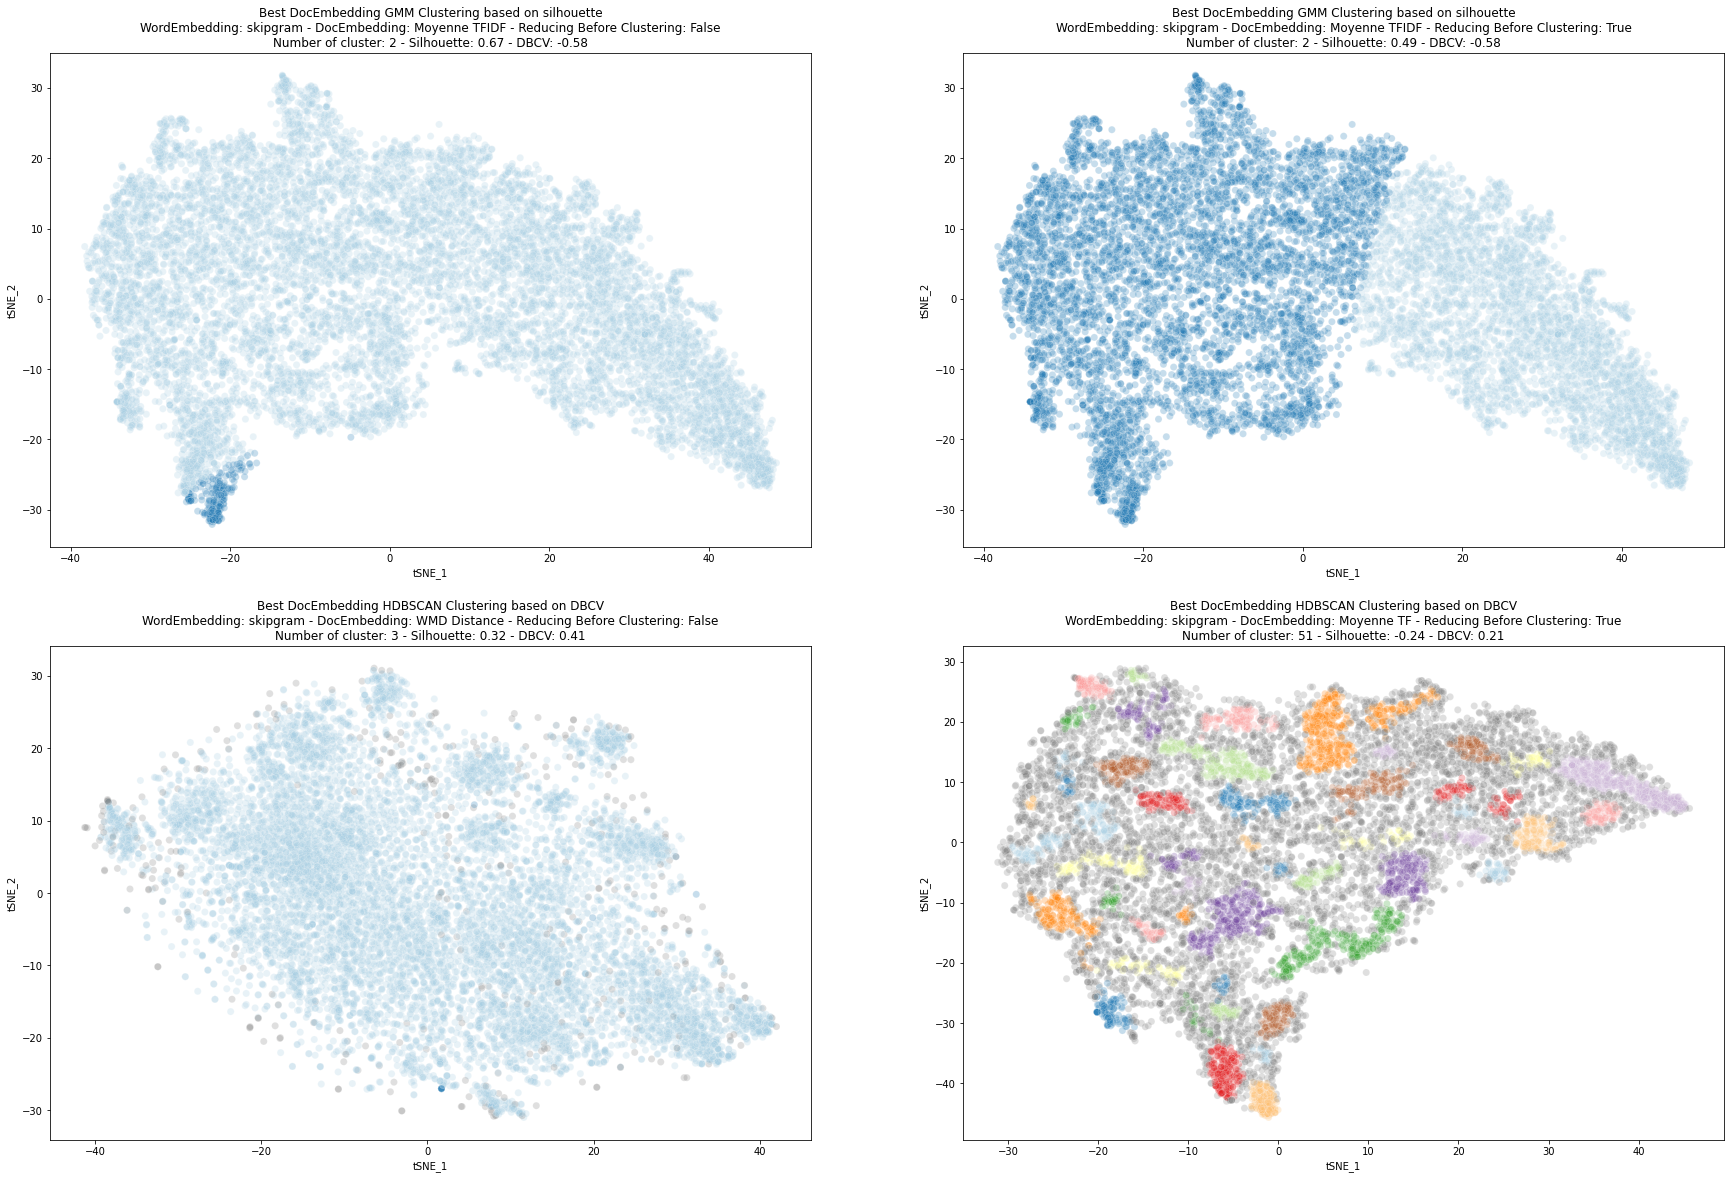

############################################################################################################################
                                                  GLOVE                                                                         
############################################################################################################################


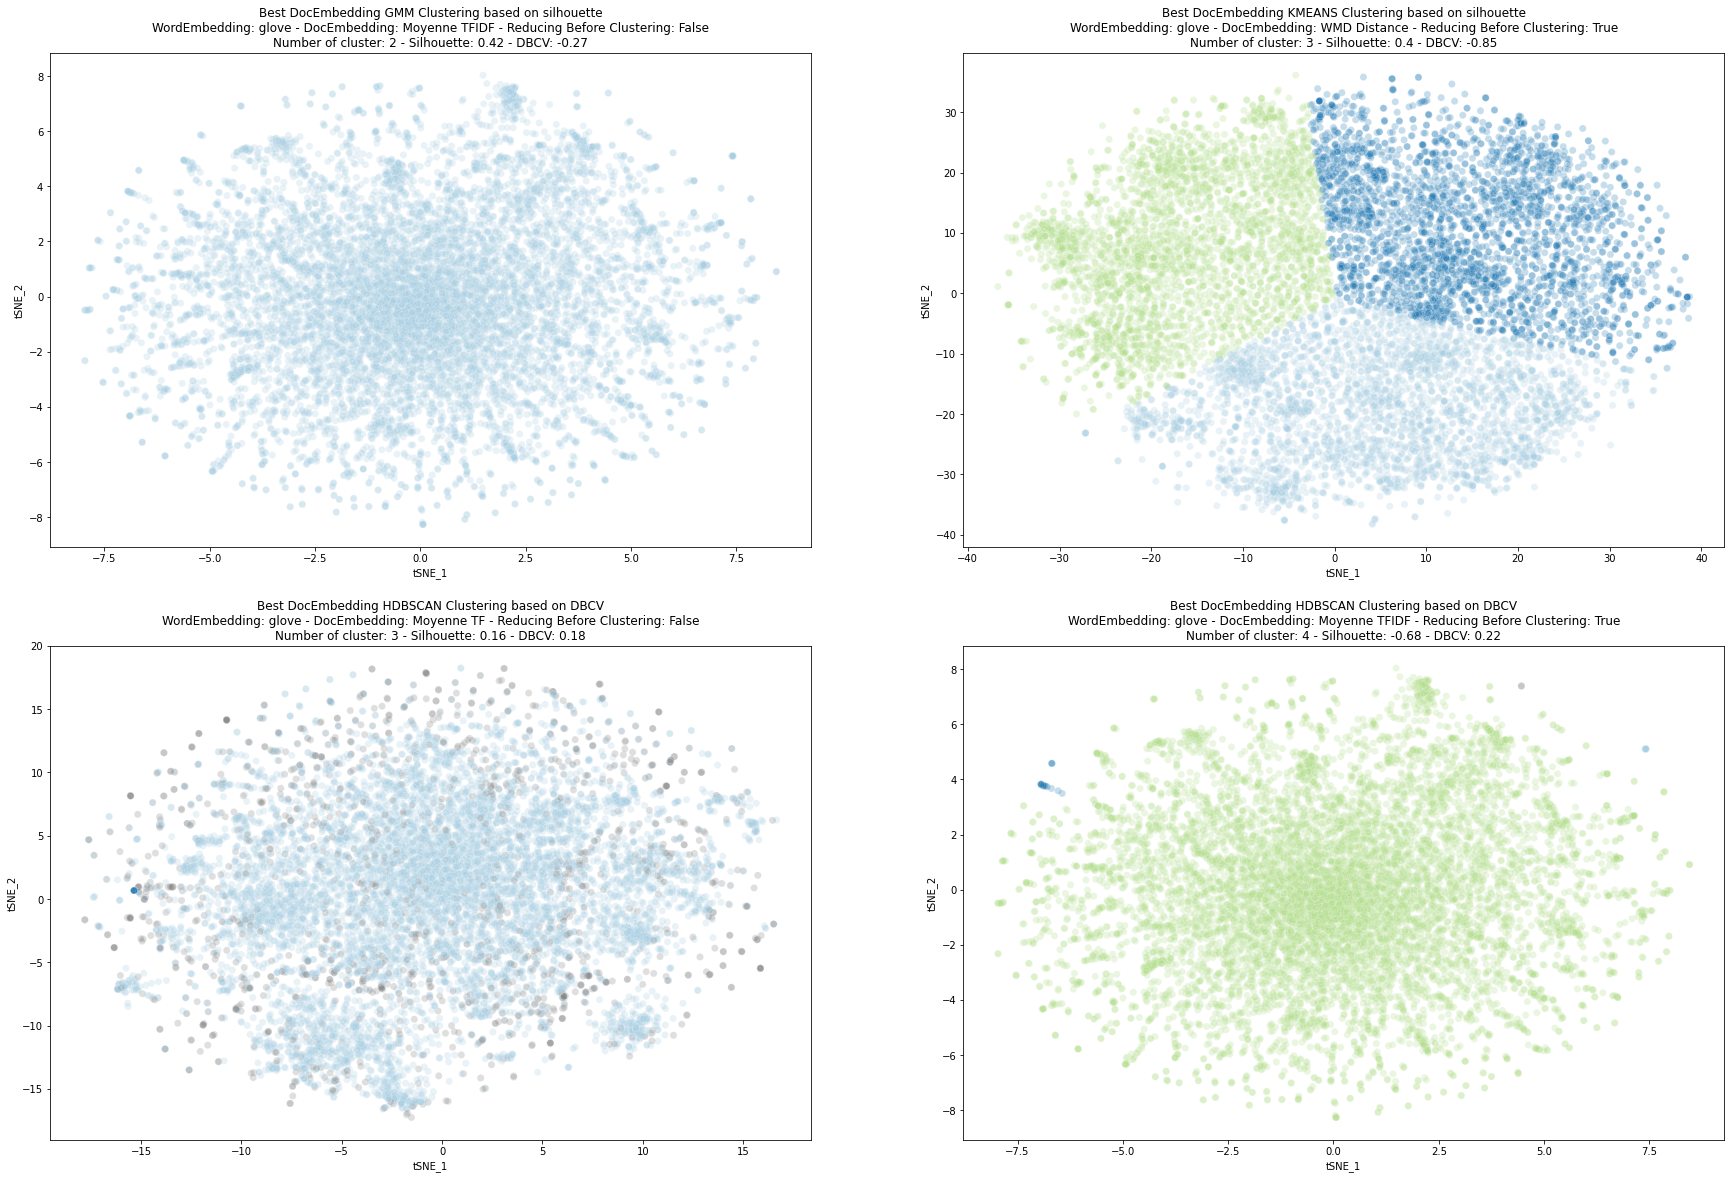

############################################################################################################################
                                                  CBOW                                                                         
############################################################################################################################


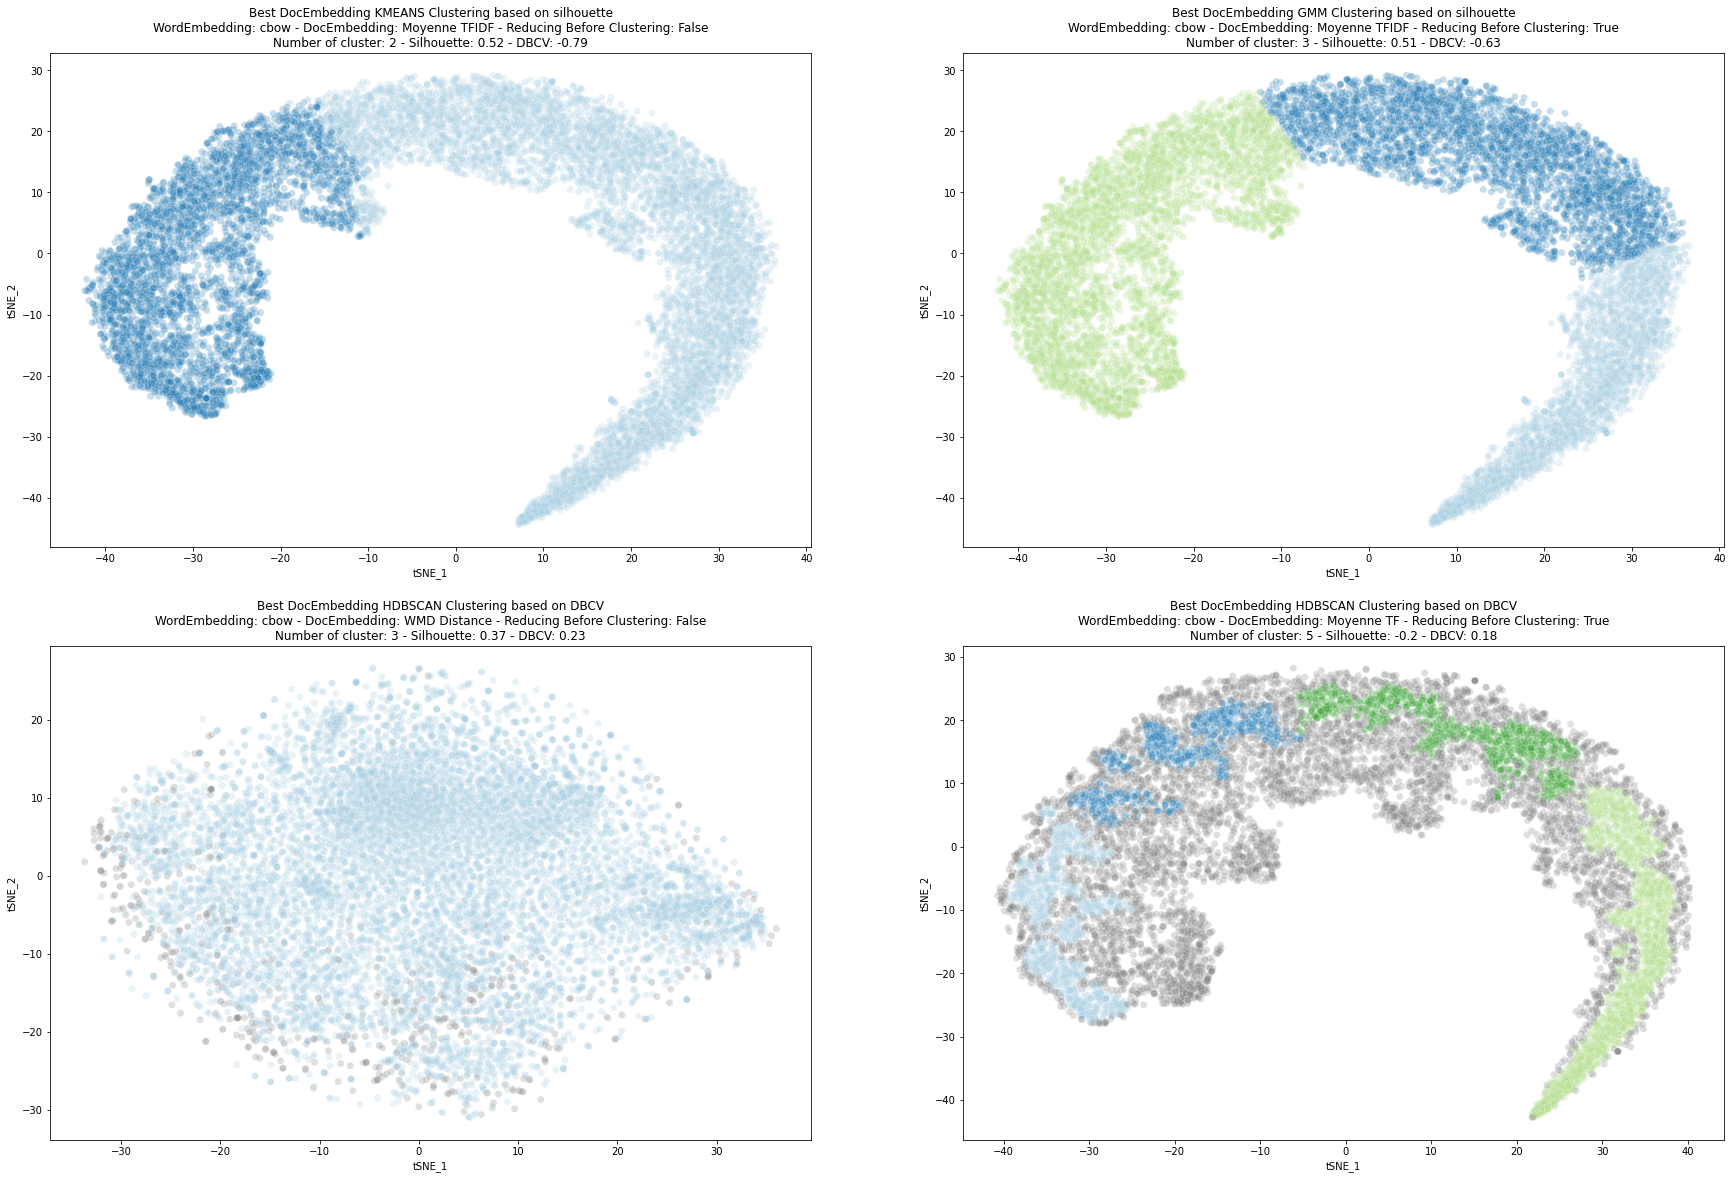

In [17]:
for modele in ["skipgram","glove","cbow"]:
    print("############################################################################################################################")
    print(f"                                                  {modele.upper()}                                                                         ")
    print("############################################################################################################################")
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_best(df_clustering_before,dict_embedding,clustering_metric="silhouette",modele=modele)
    labels_silhouette2, tsne_wmd_silhouette2, silhouette_colors2, silhouette_title2 = plot_best(df_clustering_after,dict_embedding,clustering_metric="silhouette",modele=modele)
    #DBCV
    labels_dbcv, tsne_wmd_dbcv, dbcv_colors, dbcv_title = plot_best(df_clustering_before,dict_embedding,clustering_metric="DBCV",modele=modele)
    labels_dbcv2, tsne_wmd_dbcv2, dbcv_colors2, dbcv_title2 = plot_best(df_clustering_after,dict_embedding,clustering_metric="DBCV",modele=modele)

    #Plot
    plt.figure(figsize = (30,20))

    sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(2,2,1,title=silhouette_title))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")

    sns.scatterplot(tsne_wmd_silhouette2[:,0],tsne_wmd_silhouette2[:,1], s=50, c=silhouette_colors2, alpha=0.25,ax=plt.subplot(2,2,2,title=silhouette_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")

    sns.scatterplot(tsne_wmd_dbcv[:,0],tsne_wmd_dbcv[:,1], s=50, c=dbcv_colors, alpha=0.25,ax=plt.subplot(2,2,3,title=dbcv_title))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")

    sns.scatterplot(tsne_wmd_dbcv2[:,0],tsne_wmd_dbcv2[:,1], s=50, c=dbcv_colors2, alpha=0.25,ax=plt.subplot(2,2,4,title=dbcv_title2))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")
    
    plt.show()

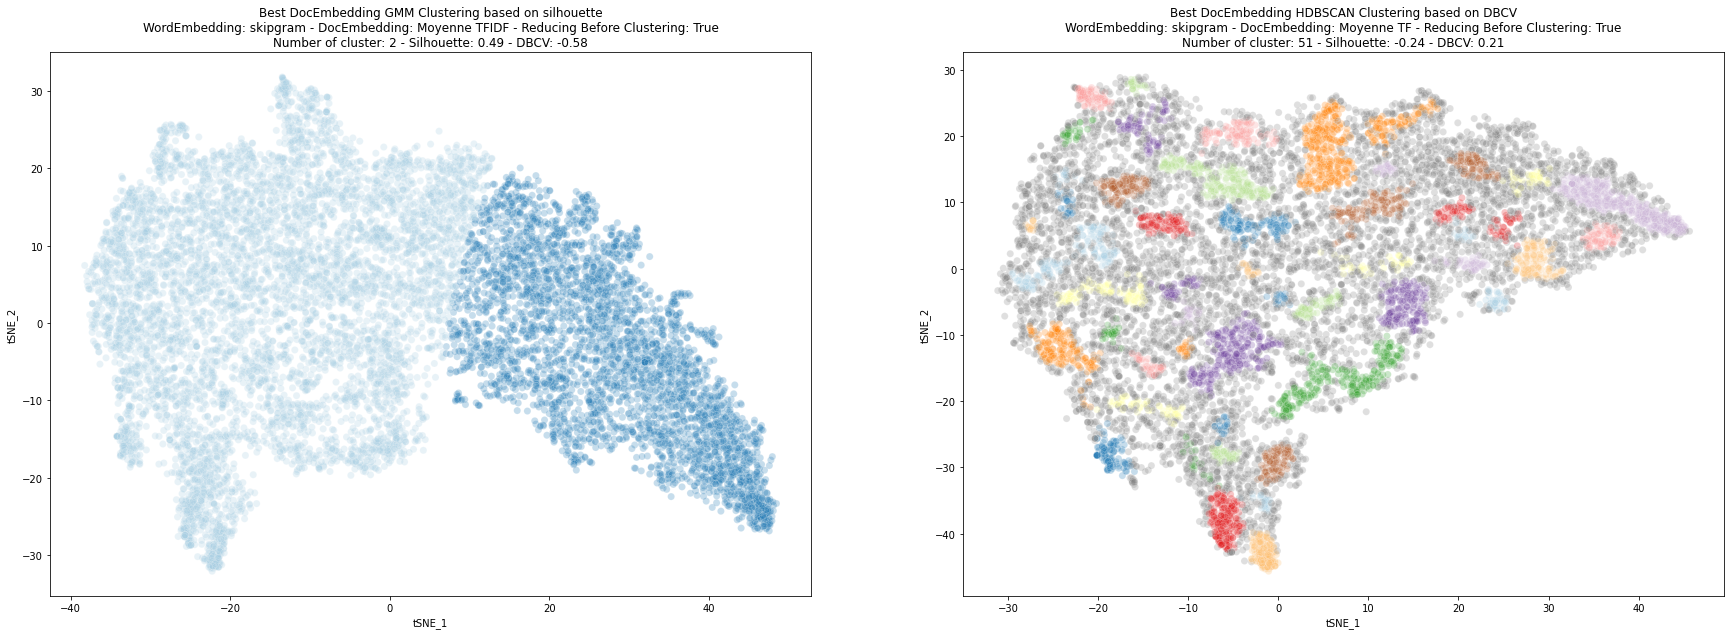

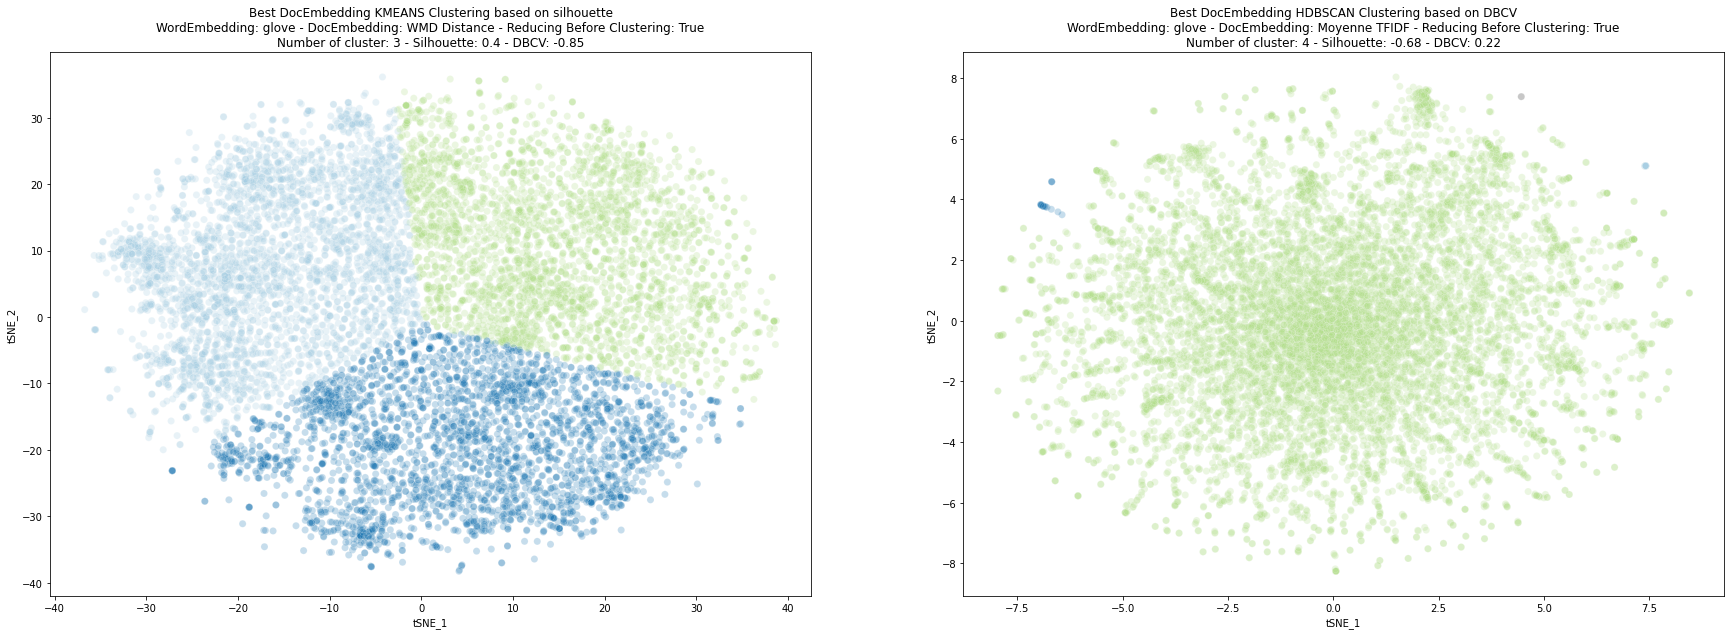

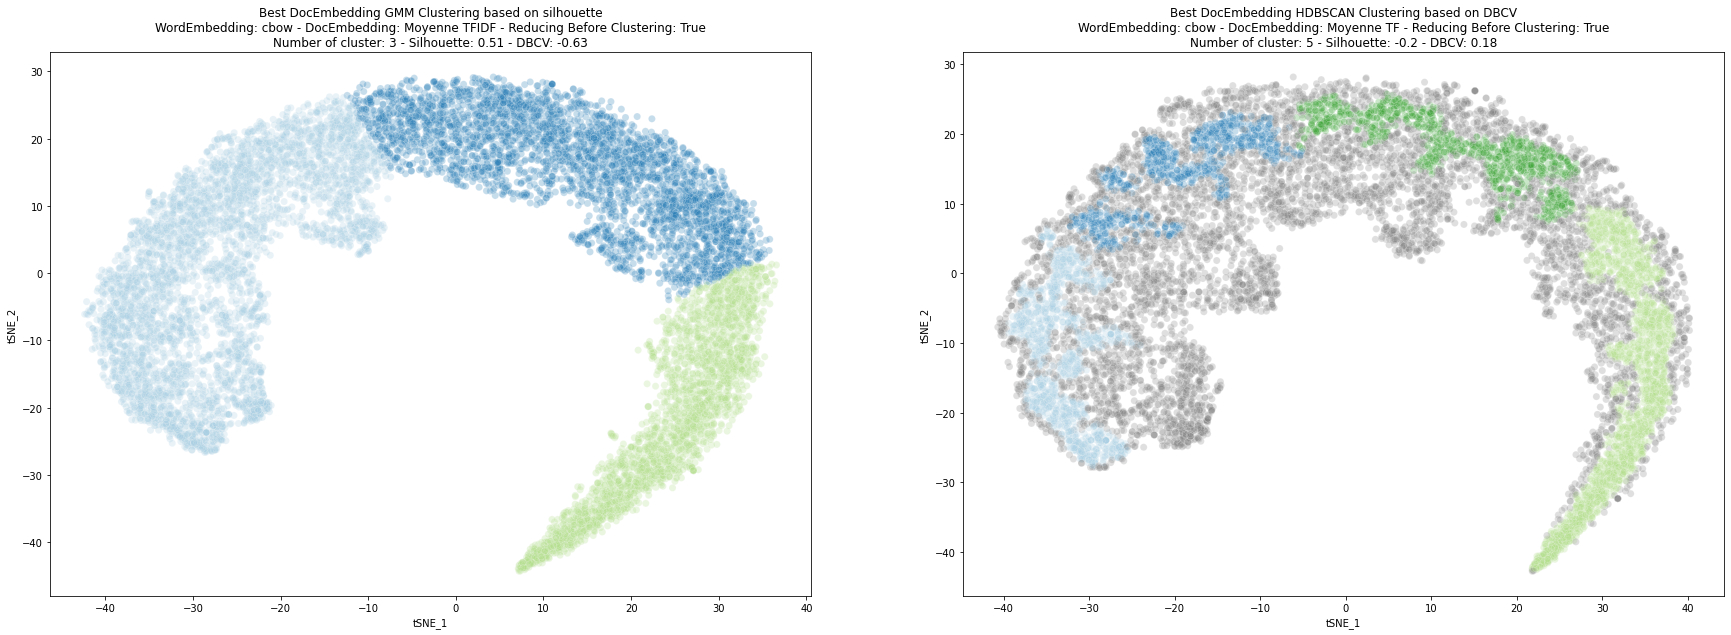

In [24]:
for modele in ["skipgram","glove","cbow"]:
    #Silhouette
    labels_silhouette, tsne_wmd_silhouette, silhouette_colors, silhouette_title = plot_best(df_clustering_after,dict_embedding,clustering_metric="silhouette",modele=modele)
    #DBCV
    labels_dbcv, tsne_wmd_dbcv, dbcv_colors, dbcv_title = plot_best(df_clustering_after,dict_embedding,clustering_metric="DBCV",modele=modele)

    #Plot
    plt.figure(figsize = (30,10))

    sns.scatterplot(tsne_wmd_silhouette[:,0],tsne_wmd_silhouette[:,1], s=50, c=silhouette_colors, alpha=0.25,ax=plt.subplot(1,2,1,title=silhouette_title))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")


    sns.scatterplot(tsne_wmd_dbcv[:,0],tsne_wmd_dbcv[:,1], s=50, c=dbcv_colors, alpha=0.25,ax=plt.subplot(1,2,2,title=dbcv_title))
    plt.xlabel("tSNE_1")
    plt.ylabel("tSNE_2")

    
    plt.show()